# Trend Analysis

##### Looking at the first Bar Chart it can be seen that Honolulu, HI had a maximum of slightly less than 7 inches of rain in last twelve months. Months with more than 3 inches of rain where September, October, February, April, and July.

##### The most active weather station indicates the lowest temperature measured was 54.0°F,  the highest temperature measured was 85.0°F, and average temperature measured was 71.7°F over the last twelve months.

##### Observing the aggregated normals data for our trip date range helps us find the daily normals for the trip dates (2017-03-17 to 2017-04-09). The visualization labeled 'Aggregated Normals (Daily) 2017-03-17 to 2017-04-09' shows the temperature ranges for the trip (low ~60°F and high around 80°F) while the avg. temperature stays around 70°F over the course of the trip.

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Declace inspector and get the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

## Inspect Tables

In [11]:
# Use the inspector that was declared earlier to get each tables column names and data contained within
print("Measurement Table")
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print("#################################")
print("Station Table")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

Measurement Table
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
#################################
Station Table
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

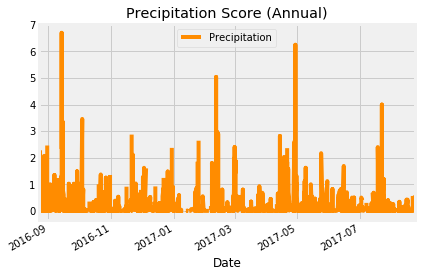

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
maxDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the first element of the tuple
maxDate = maxDate[0]

# Calculate the date 1 year ago from today
# Set days to 366 so starting day is included
priorYear = dt.datetime.strptime(maxDate, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the date and precipitation scores
queryYear = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= priorYear).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcpDF = pd.DataFrame(queryYear,columns=['Date', 'Precipitation'])

# Change datatype from element to datetime object on Pandas, this standardizes all date data
prcpDF['Date'] = pd.to_datetime(prcpDF['Date'], format='%Y-%m-%d')

# Set the index to date dolumn
prcpDF.set_index('Date', inplace=True)

# Sort the dataframe by date (index)
prcpDF = prcpDF.sort_values(by='Date',ascending=True)

# Preview DF
#prcpDF.head()

# Use Pandas Plotting with Matplotlib to plot the data
prcpDF.plot(title="Precipitation Score (Annual)", color='darkorange')
plt.legend(loc='upper center')
plt.savefig("Images/Precipitation.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpDF.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
availStat = session.query(Measurement.station).distinct().count()
print(f'# of Stations Available: {availStat}')

# of Stations Available: 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activeStat = session.query(Measurement.station, \
                           func.count(Measurement.station)).group_by\
                            (Measurement.station).order_by\
                            (func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
activeStat

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Which station has the highest number of observations?
# Solve this by pulling in both columns of the indexed 0 station
mostActvStat = activeStat[0][0]
numberObser = activeStat[0][1]
print(f"Most Active Station: {mostActvStat}     # of Observations: {numberObser}")

Most Active Station: USC00519281     # of Observations: 2772


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostActvStatTemps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter\
                                    (Measurement.station == mostActvStat).all()
print(f"Most Active Station Temperatures (°F)")
print(f"Low: {mostActvStatTemps[0][0]}°     High: {mostActvStatTemps[0][1]}°     Average: {round(mostActvStatTemps[0][2], 1)}°")


Most Active Station Temperatures (°F)
Low: 54.0°     High: 85.0°     Average: 71.7°


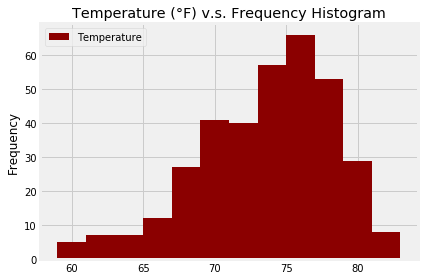

In [18]:
# Choose the station with the highest number of temperature observations.
mostTempStat = session.query(Measurement.station, func.count(Measurement.tobs)).group_by\
                (Measurement.station).order_by\
                (func.count(Measurement.station).desc()).first()
mostTempStat = mostTempStat[0]
# Query the last 12 months of temperature observation data for
# this station and plot the results as a histogram

# Query is looking at the date we determined earlier that is one year back and filtering
# on all dates greater than or equal to, so this brings us a full year back from most recent date
tempObv = session.query(Measurement.tobs).filter\
                            (Measurement.date >= priorYear).filter\
                            (Measurement.station == mostTempStat).all()
tempObv = pd.DataFrame(tempObv, columns=['Temperature'])

# Construct histogram using 12 bins for the 12 months of the year
tempObv.plot.hist(bins=12, title="Temperature (°F) v.s. Frequency Histogram", color='darkred')
plt.tight_layout()
plt.savefig("Images/TempVSFreq.png")
plt.show()

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calcTemps(startDate, endDate):
#     TMIN, TAVG, and TMAX for a list of dates.
#     Arguments:
#         startDate (string): A date string in the format %Y-%m-%d
#         endDate (string): A date string in the format %Y-%m-%d
#     Returns:
#         tripMin, tripAvg, and tripMax
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),\
                     func.max(Measurement.tobs)).\
        filter(Measurement.date >= startDate).filter(Measurement.date <= endDate).all()

# function usage example
print(calcTemps('2017-03-17','2017-04-09'))

[(65.0, 74.04794520547945, 80.0)]


## Trip Climate Analysis

In [20]:
# Use your previous function `calcTemps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripDate = calcTemps('2017-03-17','2017-04-09')
tripDate

[(65.0, 74.04794520547945, 80.0)]

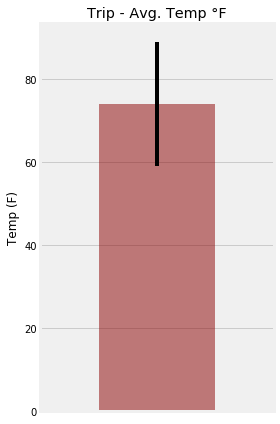

In [21]:
# Create a dataframe with the calculated tripMin, tripAvg, and tripMax values
tripTempDF = pd.DataFrame(tripDate, columns = ['tripMin', 'tripAvg', 'tripMax'])
# Preview the DF
#tripTempDF

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tempMax-tempMin) value as the y error bar (yerr)
tripTempDF.plot.bar(y='tripAvg', yerr=(tripTempDF['tripMax']-tripTempDF['tripMin']), 
                    title='Trip - Avg. Temp °F', color='darkred', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1,1.0))
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.gca().legend_.remove()
#plt.savefig("Images/TripAvgTemp.png")
plt.show()


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(startDate, endDate):
                # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        starDate (string): A date string in the format %Y-%m-%d
        endDate (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, 
        latitude, longitude, and elevation in descending order.
    """
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).\
filter(Measurement.date >= startDate).\
filter(Measurement.date <= endDate).\
group_by(Measurement.station).\
order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-03-17','2017-04-09'))

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.35), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.19), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.12), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data 
# matching a specific month and day)
def dailyNormals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()    
dailyNormals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
startDate = '2017-03-17'
endDate = '2017-04-09'

# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= startDate).\
filter(Measurement.date <= endDate).\
group_by(Measurement.date).all()
# Preview dates query
#print(dates)

# Use list comprehension to get the elements in the tuple from the dates query 
tripDates = [x[0] for x in dates]
# Preview trip dates
#print(tripDates)

# Stip off the year and save a list of %m-%d strings
tripDatesStripped = [x[5:] for x in tripDates]
# Preview modifed dates
#print(tripDatesStripped)

# Find the start month/day and the end month/day 
startMonthDay = tripDatesStripped[0]
endMonthDay = tripDatesStripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
dailyNormals = [session.query(func.min(Measurement.tobs),
                             func.avg(Measurement.tobs),
                             func.max(Measurement.tobs)).filter(func.strftime(
'%m-%d', Measurement.date) >= startMonthDay).filter(func.strftime(
    '%m-%d', Measurement.date) <= endMonthDay).\
                group_by(func.strftime('%m-%d', Measurement.date)).all()]
dailyNormals = dailyNormals[0]
print('Aggregated Normals (Daily) 2017-03-17 to 2017-04-09')
dailyNormals

Aggregated Normals (Daily) 2017-03-17 to 2017-04-09


[(57.0, 68.54, 75.0),
 (57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0),
 (65.0, 71.75471698113208, 77.0),
 (63.0, 70.79629629629629, 78.0),
 (62.0, 71.5, 77.0),
 (63.0, 71.5, 78.0),
 (64.0, 71.38, 80.0),
 (63.0, 71.53846153846153, 80.0),
 (59.0, 71.51785714285714, 82.0),
 (58.0, 71.35714285714286, 77.0),
 (62.0, 72.17543859649123, 79.0),
 (61.0, 71.875, 79.0),
 (60.0, 71.87931034482759, 80.0),
 (53.0, 71.82142857142857, 79.0),
 (55.0, 72.2280701754386, 78.0),
 (58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0)]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the
# `trip_dates` range as the `date` index

# Create pandas dataframe using prior queries
dailyNormalsDF = pd.DataFrame(dailyNormals, columns=['tripMin', 'tripAvg', 'tripMax'])

# Add tripDates to DataFrame above
dailyNormalsDF['date'] = tripDates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
dailyNormalsDF['date'] = pd.to_datetime(dailyNormalsDF['date'], format='%Y-%m-%d')

# Set index to date
dailyNormalsDF.set_index('date',inplace=True)

# Preview Dataframe
dailyNormalsDF.head()

,tripMin,tripAvg,tripMax
date,,,
2017-03-17,57.0,68.540000,75.0
2017-03-18,57.0,67.784314,76.0
2017-03-19,60.0,69.100000,75.0
2017-03-20,62.0,70.117647,80.0
2017-03-21,60.0,71.076923,77.0


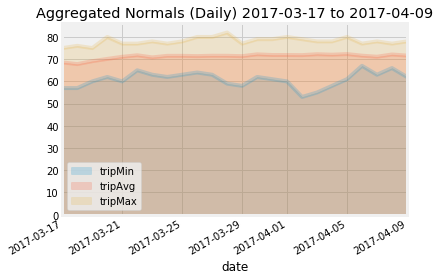

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
# x_compat = True cleans up the date formatting on the X-Axis
dailyNormalsDF.plot(kind='area', alpha=.2, stacked=False, x_compat=True, \
                    title='Aggregated Normals (Daily) 2017-03-17 to 2017-04-09')
plt.tight_layout()
#plt.savefig("Images/DailyNormals.png")
plt.show()